# Turtles All The Way Down

This notebook implements the K-means clustering algorithm to see if we can successfully cluster two species of turtle hatchlings based on a few basic morphometrics––length, width, depth, and weight.

Data comes from NOAA, and I've already aggregated and cleaned it for our purposes.

## The Plan
To keep things nice and visual, let's limit ourselves to two measurements: <b>WEIGHTGR</b> (weight, in grams) and <b>LENGTHCM</b> (length, in centimeters). We'll also min-max scale the data, so they each coordinate has the same spread.

MinMax scaling is computed on each column as follows:

$$transformed = \frac{observation-min}{max-min}$$

## The Algorithm
The algorithm we'll be exploring works as follows:

1. Choose two points P and Q randomly from the dataset to be the centroids. These centroids will define our clusters.

2. Compute the distance from centroid P and centroid Q to every point in the dataset.

3. Each point in the dataset has two distances computed––one to centroid P and one to centroid Q. Assign the point to the closer centroid. This divides the set of observations into two clusters.

4. Average the coordinates of all points assigned to P, then update P's coordinates to these means.

5. Average the coordinates of all points assigned to Q, then update Q's coordinates to these means.

6. Repeat steps 2-5 until no points are reassigned.

In [154]:
import pandas as pd

# The column 'Unnamed: 0' contains an index from the larger dataset, so we'll
# drop it.
def load_data():
    df = pd.read_csv('sample.csv').drop(axis=1, labels=['Unnamed: 0'])[['WEIGHTGR', 'LENGTHCM', 'SPECIES']]
    df['WEIGHT'] = (df.WEIGHTGR - df.WEIGHTGR.min()) / (df.WEIGHTGR.max() - df.WEIGHTGR.min())
    df['LENGTH'] = (df.LENGTHCM - df.LENGTHCM.min()) / (df.LENGTHCM.max() - df.LENGTHCM.min())
    return df

load_data()

,WEIGHTGR,LENGTHCM,SPECIES,WEIGHT,LENGTH
0,20.0,4.79,loggerhead,0.714286,0.927711
1,21.6,4.65,loggerhead,0.877551,0.759036
2,20.6,4.69,loggerhead,0.775510,0.807229
3,19.2,4.70,loggerhead,0.632653,0.819277
4,19.7,4.62,loggerhead,0.683673,0.722892
5,21.0,4.72,loggerhead,0.816327,0.843373
6,22.8,4.85,loggerhead,1.000000,1.000000
7,21.9,4.60,loggerhead,0.908163,0.698795
8,19.3,4.74,loggerhead,0.642857,0.867470
9,20.8,4.68,loggerhead,0.795918,0.795181


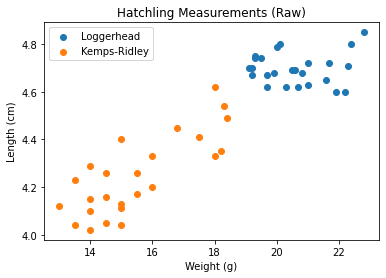

In [155]:
import matplotlib.pyplot as plt
df = load_data()

plt.scatter(df[df.SPECIES == 'loggerhead'].WEIGHTGR, df[df.SPECIES == 'loggerhead'].LENGTHCM)
plt.scatter(df[df.SPECIES == 'kemps-ridley'].WEIGHTGR, df[df.SPECIES == 'kemps-ridley'].LENGTHCM)
plt.legend(['Loggerhead', 'Kemps-Ridley'])
plt.xlabel('Weight (g)')
plt.ylabel('Length (cm)')
plt.title('Hatchling Measurements (Raw)');

These groups are cleanly separated, so in theory, we'll be able to find the distinct clusters.

Note the different scales on the axes. After min-max scaling, we have the same units on both axes, which will help prevent one measurement from dominating the distance measurement.

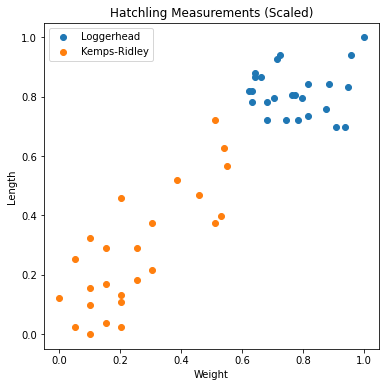

In [156]:
plt.figure(figsize=(6,6))
plt.scatter(df[df.SPECIES == 'loggerhead'].WEIGHT, df[df.SPECIES == 'loggerhead'].LENGTH)
plt.scatter(df[df.SPECIES == 'kemps-ridley'].WEIGHT, df[df.SPECIES == 'kemps-ridley'].LENGTH)
plt.legend(['Loggerhead', 'Kemps-Ridley'])
plt.xlabel('Weight')
plt.ylabel('Length')
plt.title('Hatchling Measurements (Scaled)');

In [170]:
import numpy as np

def get_centroids(df, random_state=None):
    sample = df.sample(2, random_state=random_state)
    p = [sample.iloc[0]['WEIGHT'], sample.iloc[0]['LENGTH']]
    q = [sample.iloc[1]['WEIGHT'], sample.iloc[1]['LENGTH']]
    print('P:', p)
    print('Q:', q)
    return p, q

def compute_clusters(df, p, q):
    # distance to P
    df['P'] = np.sqrt((df.WEIGHT - p[0])**2 + (df.LENGTH - p[1])**2)
    
    # distance to Q
    df['Q'] = np.sqrt((df.WEIGHT - q[0])**2 + (df.LENGTH - q[1])**2)
    
    # return a series containing the clusters
    return df[['P', 'Q']].idxmin(axis=1)

def kmeans(df, max_iter=50, initial_p=None, initial_q=None, random_state=None):
    if initial_p == None or initial_q == None:
        p, q = get_centroids(df, random_state=random_state)
    else:
        p=initial_p
        q=initial_q
        
    iteration = 0
    df['iter_0'] = compute_clusters(df, p, q) # unassigned
    
    while (iteration < max_iter):
        iteration += 1
        df[f'iter_{iteration}'] = compute_clusters(df, p, q)
        
        p = [df[df.iloc[:,-1] == 'P']['WEIGHT'].mean(), df[df.iloc[:,-1] == 'P']['LENGTH'].mean()]
        q = [df[df.iloc[:,-1] == 'Q']['WEIGHT'].mean(), df[df.iloc[:,-1] == 'Q']['LENGTH'].mean()]
        
        if sum(df.iloc[:,-1].eq(df.iloc[:,-2])) == len(df):
            print(f'Clusters converged on iteration #{iteration}')
            break
        
    return df, p, q

df = load_data()[['WEIGHT', 'LENGTH', 'SPECIES']]
kmeans(df)[0].head()

P: [0.5408163265306123, 0.626506024096386]
Q: [0.9591836734693875, 0.9397590361445786]
Clusters converged on iteration #1


,WEIGHT,LENGTH,SPECIES,P,Q,iter_0,iter_1
0,0.714286,0.927711,loggerhead,0.347586,0.245194,Q,Q
1,0.877551,0.759036,loggerhead,0.361876,0.198304,Q,Q
2,0.775510,0.807229,loggerhead,0.296213,0.226495,Q,Q
3,0.632653,0.819277,loggerhead,0.213529,0.348049,P,P
4,0.683673,0.722892,loggerhead,0.172332,0.350624,P,P


P: [0.2040816326530612, 0.13253012048192808]
Q: [0.9081632653061222, 0.6987951807228916]
Clusters converged on iteration #1


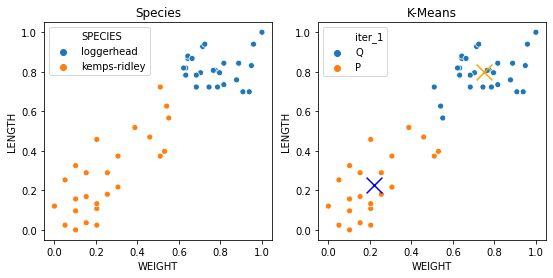

In [174]:
import seaborn as sns
k, p, q = kmeans(df)
fig, (sp, km) = plt.subplots(1, 2, figsize=(9,4))
sns.scatterplot(k.WEIGHT, k.LENGTH, hue=k.SPECIES, ax=sp)
sns.scatterplot(k.WEIGHT, k.LENGTH, hue=k.iter_1, ax=km)
sp.set_title('Species')
km.set_title('K-Means')
km.scatter(p[0], p[1], marker='x', s=250, color='blue')
km.scatter(q[0], q[1], marker='x', s=250, color='orange')
plt.savefig('kmeans_failure.png');

Perfect failure!